# Лабораторная работа №5. Catboost.
## Выполнил Коршиков Владислав Игоревич, группа 6133-010402D

In [274]:
# Подключаемся к Google Диск
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [275]:
# Устанавливаем Catboost
! pip install catboost shap ipywidgets
! jupyter nbextension enable --py widgetsnbextension

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


In [276]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split, cross_val_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.tree import DecisionTreeClassifier


from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import Pipeline


from sklearn import metrics
from sklearn.metrics import recall_score, precision_score, f1_score, classification_report

import catboost
from catboost import *
from catboost import datasets
from catboost.utils import get_roc_curve


import sklearn.model_selection
import sklearn.metrics

import warnings
import sys  
if not sys.warnoptions:
    warnings.simplefilter("ignore")

Для данной лабораторной работы использовался DataFrame, содержащий все машины из Gran Turismo 6: https://www.kaggle.com/prasertk/gran-turismo-6-cars/version/1

Категориальные: car_type, drive

Числовые: price, hp, weight, torque

In [277]:
# Загрузим датафрейм и удалим строчки с пустующими значениями
gran_turismo_a = pd.read_csv("/content/drive/MyDrive/gran_turismo_gt6.csv") 
gran_turismo_2=gran_turismo_a
gran_turismo=gran_turismo_2.dropna(axis=0)
gran_turismo.isnull().sum()

brand       0
model       0
car_type    0
img_url     0
price       0
drive       0
hp          0
weight      0
torque      0
w_kg        0
dtype: int64

In [278]:
gran_turismo

,brand,model,car_type,img_url,price,drive,hp,weight,torque,w_kg
0,AC Cars,427 S/C '66,Street,https://www.kudosprime.com/gt6/images/cars/gt6...,423200.0,FR,478.0,1311.0,651.0,272 to ? W/Kg
1,AEM,S2000,Tuned,https://www.kudosprime.com/gt6/images/cars/gt6...,100000.0,FR,430.0,1155.0,495.0,278 to 345 W/Kg
3,Abarth,500 '09,Street,https://www.kudosprime.com/gt6/images/cars/gt6...,29500.0,FF,133.0,1035.0,180.0,96 to 251 W/Kg
4,Abarth,Grande Punto '09,Street,https://www.kudosprime.com/gt6/images/cars/gt6...,27000.0,FF,153.0,1240.0,230.0,92 to ? W/Kg
5,Acura,CL 3.2 Type-S '01,Street,https://www.kudosprime.com/gt6/images/cars/gt6...,32180.0,FF,260.0,1592.0,315.0,122 to ? W/Kg
...,...,...,...,...,...,...,...,...,...,...
1265,Volkswagen,Scirocco R '10,Street,https://www.kudosprime.com/gt6/images/cars/gt6...,51500.0,FF,252.0,1410.0,330.0,133 to 298 W/Kg
1266,Volkswagen,W12 Nardo '01,Street,https://www.kudosprime.com/gt6/images/cars/gt6...,1250000.0,MR,574.0,1300.0,620.0,329 to ? W/Kg
1267,Volvo,240 GLT Estate '88,Street,https://www.kudosprime.com/gt6/images/cars/gt6...,15920.0,FR,127.0,1890.0,190.0,50 to ? W/Kg
1268,Volvo,C30 R-Design '09,Street,https://www.kudosprime.com/gt6/images/cars/gt6...,42000.0,FF,227.0,1430.0,319.0,118 to ? W/Kg


In [279]:
#Уберём столбцы, которые не оказывают влияние на целевое значение, чтобы с датафреймом было проще работать
# Также, нам необходимо заменить tuned на street в car_type, так как tuned является подклассом race, но это выделение нигде не используется
gran_turismo.pop('w_kg')
gran_turismo.pop('model')
gran_turismo.pop('img_url')
gran_turismo['car_type'] = np.where((gran_turismo.car_type == 'Tuned'), 'Race', gran_turismo.car_type)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [280]:
#Разобьём датасет на тестовую и тренировочную датафреймы
gran_turismo_3 = gran_turismo.copy()
gran_turismo_3.pop('brand')


gran_turismo_3 = gran_turismo_3[gran_turismo_3.drive != 'RR']


# 1.0. Применить классификатор CatBoostClassifier к вашему набору данных.

In [281]:
# Выделим целевое значение
y=  gran_turismo_3.car_type
print(y)
X=gran_turismo_3.drop("car_type", axis=1)
X.head()



0       Street
1         Race
3       Street
4       Street
5       Street
         ...  
1265    Street
1266    Street
1267    Street
1268    Street
1269    Street
Name: car_type, Length: 1013, dtype: object


,price,drive,hp,weight,torque
0,423200.0,FR,478.0,1311.0,651.0
1,100000.0,FR,430.0,1155.0,495.0
3,29500.0,FF,133.0,1035.0,180.0
4,27000.0,FF,153.0,1240.0,230.0
5,32180.0,FF,260.0,1592.0,315.0


In [282]:
# Теперь необходимо задать колонки категориальных признаков
cat_features = list([1])
print(cat_features)

[1]


In [283]:
# Теперь необходимо разбить датафрейм на тестовую и обучающую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, stratify=y, random_state=0)



# 1.1. Переходим к построению модели Catboost

In [284]:
model = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    loss_function='Logloss', 
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_test, y_test),
    verbose = False
    
)

print(f'Model is fitted: {str(model.is_fitted())}')
print(f'Model params: {model.get_params()}')

Model is fitted: True
Model params: {'iterations': 100, 'learning_rate': 0.1, 'loss_function': 'Logloss'}


In [285]:
# Определим итерацию с наименьшим logloss

model.get_best_iteration()

98

In [286]:
# Определим значения для данной итерации

model.best_score_

{'learn': {'Logloss': 0.14572914167920292},
 'validation': {'Logloss': 0.18546620538706224}}

In [287]:
print(sklearn.metrics.classification_report( 
    model.predict(X_test), y_test, target_names=["two", "four"]
) )

              precision    recall  f1-score   support

         two       0.81      0.86      0.83        50
        four       0.97      0.95      0.96       204

    accuracy                           0.93       254
   macro avg       0.89      0.91      0.90       254
weighted avg       0.93      0.93      0.93       254



# 2.0. Применить регрессию CatBoostRegressor к набору данных для регрессии.

In [288]:
# Добавим в список категориальные признаки

gran_turismo_4 = gran_turismo_3.copy()
col = list(['car_type', 'drive'])

for i in col: 
    gran_turismo_4[i] = pd.factorize(gran_turismo_3[i])[0]

In [289]:
y_r=  gran_turismo_4.car_type
print(y)
X_r=gran_turismo_4.drop("car_type", axis=1)
X.head()

0       Street
1         Race
3       Street
4       Street
5       Street
         ...  
1265    Street
1266    Street
1267    Street
1268    Street
1269    Street
Name: car_type, Length: 1013, dtype: object


,price,drive,hp,weight,torque
0,423200.0,FR,478.0,1311.0,651.0
1,100000.0,FR,430.0,1155.0,495.0
3,29500.0,FF,133.0,1035.0,180.0
4,27000.0,FF,153.0,1240.0,230.0
5,32180.0,FF,260.0,1592.0,315.0


In [290]:
X_train_r, X_test_r, y_train_r, y_test_r = sklearn.model_selection.train_test_split(
    X_r, y_r, random_state = 0
)

# 2.1. Вывести номер итерации и значения метрик (MAE и MSE) для наилучшей итерации

In [291]:
# Метрика MSE

# Необходимо создать и передать выборку КБ

model_r = CatBoostRegressor(iterations=500, learning_rate=0.1, use_best_model=True, loss_function = 'RMSE') 
model_r.fit(X_train_r, y_train_r, verbose=False, eval_set=(X_test_r, y_test_r))

In [292]:
# Выведем лучшую итерацию

model_r.get_best_iteration()

493

In [293]:
# Перейдём к подсчёту метрик

print(f'MAE: {str(sklearn.metrics.mean_absolute_error(y_test_r, model_r.predict(data=X_test_r)))}')
print(f'MSE: {str(sklearn.metrics.mean_squared_error(y_test_r, model_r.predict(data=X_test_r)))}')

MAE: 0.09677561187765914
MSE: 0.05089287762973158


In [294]:
# Метрика MAE

# Необходимо создать и передать выборку КБ

model_r = CatBoostRegressor(iterations=500, learning_rate=0.1, use_best_model=True, loss_function = 'MAE') 
model_r.fit(X_train_r, y_train_r, verbose=False, eval_set=(X_test_r, y_test_r))

In [295]:
# Выведем лучшую итерацию

model_r.get_best_iteration()

471

In [296]:
# Ещё раз подсчитаем метрики

print('MAE: ' + str(sklearn.metrics.mean_absolute_error(y_test_r, model_r.predict(data=X_test_r))))
print('MSE: ' + str(sklearn.metrics.mean_squared_error(y_test_r, model_r.predict(data=X_test_r))))

MAE: 0.09408717927297197
MSE: 0.0680880479145578


# 2.2. Построить кривые PRC и ROC. Вычислить значения PRC-AUC и ROC-AUC.

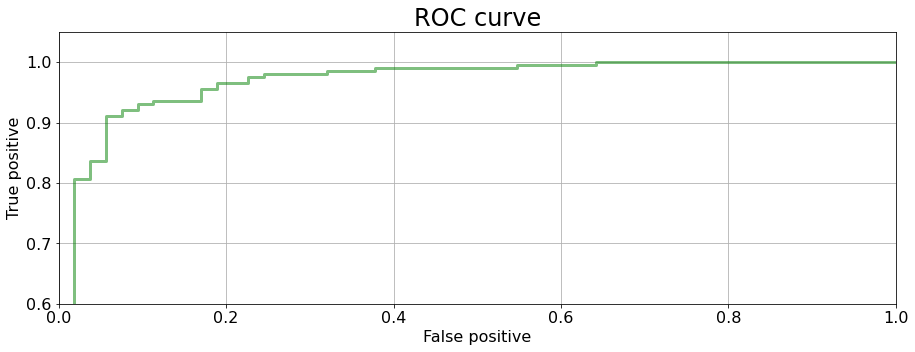

In [297]:
# Построим ROC-кривую

plt.figure(figsize=(15, 5))

plt.plot(fpr, tpr, color='green', lw=3, label='ROC curve (area = %0.3f)' % roc_auc, alpha=0.5)

 #настроим область отображения, размеры шрифта, подписи и тд
plt.xlim([0.0, 1.0])
plt.ylim([0.6, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False positive', fontsize=16)
plt.ylabel('True positive', fontsize=16)
plt.title('ROC curve', fontsize=24)
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


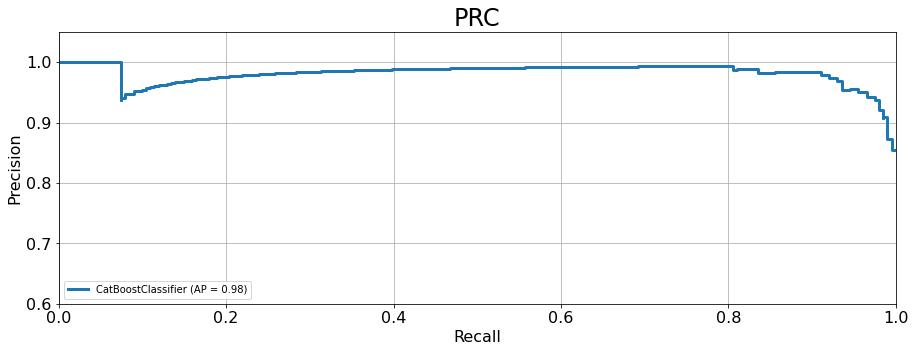

In [298]:
# Теперь построим PRC-кривую

fig, ax = plt.subplots(figsize=(15, 5))


sklearn.metrics.plot_precision_recall_curve(model, X_test, y_test, ax=ax, lw = 3)

plt.xlim([0.0, 1.0])
plt.ylim([0.6, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('Recall', fontsize=16)
plt.ylabel('Precision', fontsize=16)
plt.title('PRC', fontsize=24)

plt.show()

In [299]:
eval_pool = Pool(X_test, y_test, cat_features=cat_features) 
curve = get_roc_curve(model, eval_pool)
(fpr, tpr, thresholds) = curve
roc_auc = sklearn.metrics.auc(fpr, tpr)

# Выведем ROC AUC
print(f'ROC-AUC: {str(roc_auc)}')

# Выведем RPC AUC
s = sklearn.metrics.average_precision_score(pd.factorize(y_test)[0], model.predict_proba(X_test)[:,0]) 
print(f'RPC-AUC:  {str(s)}')

ROC-AUC: 0.9604806157889796
RPC-AUC:  0.9062107486402184
